In [17]:
# Import necessary libraries for preprocessing
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Load the dataset
Ames = pd.read_csv('~/Documents/NYCDSA/Third Project/ML_Ames_Housing/data/Ames_Housing_Price_Data.csv', index_col=0)

# Convert the below numeric features to categorical features
Ames['MSSubClass'] = Ames['MSSubClass'].astype('object')
Ames['YrSold'] = Ames['YrSold'].astype('object')
Ames['MoSold'] = Ames['MoSold'].astype('object')

# Exclude 'PID' and 'SalePrice' from features and specifically handle the 'Electrical' column
numeric_features = Ames.select_dtypes(include=['int64', 'float64']).drop(columns=['PID', 'SalePrice','BsmtFinSF2', 'BsmtUnfSF', 'BsmtFinSF1','1stFlrSF', '2ndFlrSF', 'LowQualFinSF']).columns
categorical_features = Ames.select_dtypes(include=['object']).columns.difference(['Electrical'])
electrical_feature = ['Electrical']

In [18]:
# Manually specify the categories for ordinal encoding according to the data dictionary
ordinal_order = {
    'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],  # Electrical system
    'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],  # General shape of property
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],  # Type of utilities available
    'LandSlope': ['Sev', 'Mod', 'Gtl'],  # Slope of property
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Evaluates the quality of the material on the exterior
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Evaluates the present condition of the material on the exterior
    'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Height of the basement
    'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # General condition of the basement
    'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],  # Walkout or garden level basement walls
    'BsmtFinType1': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # Quality of basement finished area
    'BsmtFinType2': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # Quality of second basement finished area
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Heating quality and condition
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Kitchen quality
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],  # Home functionality
    'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Fireplace quality
    'GarageFinish': ['None', 'Unf', 'RFn', 'Fin'],  # Interior finish of the garage
    'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Garage quality
    'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Garage condition
    'PavedDrive': ['N', 'P', 'Y'],  # Paved driveway
    'PoolQC': ['None', 'Fa', 'TA', 'Gd', 'Ex'],  # Pool quality
    'Fence': ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']  # Fence quality
}

# Extract list of ALL ordinal features from dictionary
ordinal_features = list(ordinal_order.keys())

# List of ordinal features except Electrical
ordinal_except_electrical = [feature for feature in ordinal_features if feature != 'Electrical']

# # # Helper function to fill 'None' for missing categorical data
# def fill_none(X):
#     return X.fillna("None")

# Pipeline for 'Electrical': Fill missing value with mode then apply ordinal encoding
electrical_transformer = Pipeline(steps=[
    ('impute_electrical', SimpleImputer(strategy='most_frequent')),
    ('ordinal_electrical', OrdinalEncoder(categories=[ordinal_order['Electrical']]))
])

# Pipeline for numeric features: Impute missing values using mean
numeric_transformer = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [19]:
# Pipeline for ordinal features: Fill missing values with 'None' then apply ordinal encoding
ordinal_transformer = Pipeline(steps=[
    ('impute_none', SimpleImputer(strategy='constant', fill_value='None')),  # Using SimpleImputer
    ('ordinal', OrdinalEncoder(categories=[ordinal_order[feature] for feature in ordinal_except_electrical]))
])
# Pipeline for nominal categorical features: Fill missing values with 'None' then apply one-hot encoding
nominal_features = [feature for feature in categorical_features if feature not in ordinal_features]
categorical_transformer = Pipeline(steps=[
    ('impute_none', SimpleImputer(strategy='constant', fill_value='None')),  # Using SimpleImputer
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combined preprocessor for numeric, ordinal, nominal, and specific electrical data
preprocessor = ColumnTransformer(
    transformers=[
        ('electrical', electrical_transformer, ['Electrical']),
        ('num', numeric_transformer, numeric_features),
        ('ordinal', ordinal_transformer, ordinal_except_electrical),
        ('nominal', categorical_transformer, nominal_features)
])


# Apply the preprocessing pipeline to Ames
transformed_data = preprocessor.fit_transform(Ames)

# Generate column names for the one-hot encoded features
onehot_features = preprocessor.named_transformers_['nominal'].named_steps['onehot'].get_feature_names_out()

In [20]:
# Combine all feature names
all_feature_names = ['Electrical'] + list(numeric_features) + list(ordinal_except_electrical) + list(onehot_features)

In [21]:
# Assuming RandomForest is part of your models dictionary
gbm_model = GradientBoostingRegressor(random_state=42)
# Define the full model pipeline including the preprocessor and RandomForestRegressor
gbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', gbm_model)
])
# Fit the model pipeline
gbm_pipeline.fit(Ames.drop(columns='SalePrice'), Ames['SalePrice'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('electrical',
                                                  Pipeline(steps=[('impute_electrical',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal_electrical',
                                                                   OrdinalEncoder(categories=[['Mix',
                                                                                               'FuseP',
                                                                                               'FuseF',
                                                                                               'FuseA',
                                                                                               'SBrkr']]))]),
                                                  ['Electrical']),
                                                 ('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())])...
                                                  ['Alley', 'BldgType',
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LandContour',
                                                   'LotConfig', 'MSSubClass',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature', 'MoSold',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'YrSold'])])),
                ('regressor', GradientBoostingRegressor(random_state=42))])

In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_score_gb = cross_val_score(gbm_pipeline, Ames.drop(columns='SalePrice'), Ames['SalePrice'], scoring = 'r2', cv=kf, n_jobs = -1)
print(cross_val_score_gb)
print('Avg Score:',np.mean(cross_val_score_gb))
print('Variance:',np.var(cross_val_score_gb))

[0.9162768  0.8436942  0.900398   0.93145044 0.91142455]
Avg Score: 0.9006488001721065
Variance: 0.0009105963820655203


In [23]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
gbr_check = GradientBoostingRegressor(max_depth=9, max_features='sqrt',
                                           min_samples_leaf=4, n_estimators=190,
                                           random_state=42)

gbr_check_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', gbr_check)
])

In [24]:
cross_val_score_gb = cross_val_score(gbr_check_pipeline, Ames.drop(columns='SalePrice'), Ames['SalePrice'], scoring = 'r2', cv=kf, n_jobs = -1)
print(cross_val_score_gb)
print('Avg Score:',np.mean(cross_val_score_gb))
print('Variance:',np.var(cross_val_score_gb))

[0.92229681 0.87975323 0.91048688 0.92519425 0.91713758]
Avg Score: 0.910973747306193
Variance: 0.000268677036019447


In [25]:
feature_importances = []

In [26]:
# Iterate over each split
for train_index, test_index in kf.split(Ames):
    X_train, X_test = Ames.iloc[train_index], Ames.iloc[test_index]
    y_train, y_test = Ames['SalePrice'].iloc[train_index], Ames['SalePrice'].iloc[test_index]
    # Fit the model
    gbr_check_pipeline.fit(X_train.drop(columns='SalePrice'), y_train)
    # Extract feature importances
    importances = gbr_check_pipeline.named_steps['regressor'].feature_importances_
    # Extracting feature names from the pipeline after fitting
    feature_names = []
    # Adding electrical features (assuming it's still handled as a single feature post ordinal encoding)
    feature_names.append('Electrical')
    # Adding numeric features
    feature_names.extend(numeric_features)
    # Adding ordinal features except electrical
    feature_names.extend(ordinal_except_electrical)
    # Generating one-hot encoded feature names
    onehot_features = gbr_check_pipeline.named_steps['preprocessor'].named_transformers_['nominal'].named_steps['onehot'].get_feature_names_out()
    feature_names.extend(onehot_features)
    # Ensure the lengths match
    if len(feature_names) != len(importances):
        print(f"Mismatch in feature names and importances: {len(feature_names)} vs {len(importances)}")
        continue
    # Optionally, convert feature importances to DataFrame and print or store them
    importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importances.append(importances_df)
    print(f"Feature importances for fold {len(feature_importances)}:\n", importances_df)

Feature importances for fold 1:
          Feature  Importance
0     Electrical    0.000114
1      GrLivArea    0.103193
2    LotFrontage    0.025886
3        LotArea    0.017070
4    OverallQual    0.085530
..           ...         ...
240     x24_2006    0.000311
241     x24_2007    0.000559
242     x24_2008    0.000520
243     x24_2009    0.001847
244     x24_2010    0.000288

[245 rows x 2 columns]
Feature importances for fold 2:
          Feature  Importance
0     Electrical    0.001090
1      GrLivArea    0.050530
2    LotFrontage    0.009930
3        LotArea    0.025530
4    OverallQual    0.064350
..           ...         ...
243     x24_2006    0.000630
244     x24_2007    0.000543
245     x24_2008    0.000214
246     x24_2009    0.000870
247     x24_2010    0.000249

[248 rows x 2 columns]
Feature importances for fold 3:
          Feature  Importance
0     Electrical    0.000323
1      GrLivArea    0.085483
2    LotFrontage    0.019920
3        LotArea    0.022411
4    Overall

In [27]:
import pandas as pd
# Step 1: Combine all DataFrames into one
all_importances = pd.concat(feature_importances)
all_importances

,Feature,Importance
0,Electrical,0.000114
1,GrLivArea,0.103193
2,LotFrontage,0.025886
3,LotArea,0.017070
4,OverallQual,0.085530
...,...,...
242,x24_2006,0.000270
243,x24_2007,0.000270
244,x24_2008,0.000276
245,x24_2009,0.000185


In [28]:
# Step 2: Group by 'Feature' and calculate the mean importance across all folds
aggregated_importances = all_importances.groupby('Feature').mean().reset_index()
aggregated_importances

,Feature,Importance
0,3SsnPorch,5.287632e-05
1,BedroomAbvGr,5.506666e-03
2,BsmtCond,1.013663e-03
3,BsmtExposure,2.106984e-02
4,BsmtFinType1,2.216094e-02
...,...,...
245,x9_GasA,1.720774e-05
246,x9_GasW,3.025627e-05
247,x9_Grav,1.098056e-06
248,x9_OthW,0.000000e+00


In [29]:
# Step 3: Sort the DataFrame by importance in descending order
aggregated_importances = aggregated_importances.sort_values(by='Importance', ascending=False)
aggregated_importances
aggregated_importances['Importance'] = aggregated_importances['Importance'].div(5)

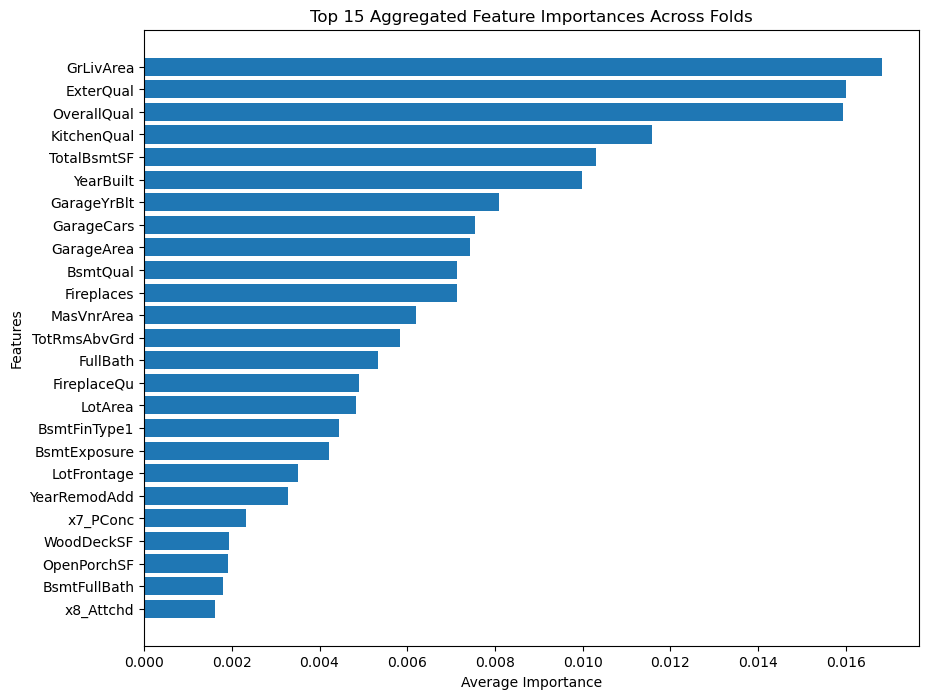

In [30]:
# Step 4: Optionally visualize the top N features
import matplotlib.pyplot as plt
# Select the top 15 features
top_features = aggregated_importances.head(25)
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Average Importance')
plt.ylabel('Features')
plt.title('Top 15 Aggregated Feature Importances Across Folds')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.show()